# Before Analysis

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
from datetime import timedelta  
from scipy import stats
from sklearn.preprocessing import StandardScaler

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Let's take a look at the original dataset

In [ ]:
df = pd.read_csv("data.csv")

In [ ]:
df.shape

(1513719, 4)

In [ ]:
df.head()

,Unnamed: 0,merchant,time,amount_usd_in_cents
0,1,faa029c6b0,2034-06-17 23:34:14,6349
1,2,ed7a7d91aa,2034-12-27 00:40:38,3854
2,3,5608f200cf,2034-04-30 01:29:42,789
3,4,15b1a0d61e,2034-09-16 01:06:23,4452
4,5,4770051790,2034-07-22 16:21:42,20203


In [ ]:
df.isnull().sum()

Unnamed: 0             0
merchant               0
time                   0
amount_usd_in_cents    0
dtype: int64

Now, we split the time column into multi columns 

In [ ]:
# create date (yyyy-mm-dd) and daytime (HH:MM:SS)
df[['date', 'daytime']] = df.time.str.split(' ', expand=True)
df[['year', 'month', 'day']] = df.date.str.split('-', expand=True)

# convert date to datetime
df['date'] = df.date.astype('datetime64')

# creat day of week, and split them into dummy variables
df['day_of_week'] = df['date'].dt.day_name()
day_of_week = pd.get_dummies(df.day_of_week)
df[day_of_week.columns] = day_of_week[day_of_week.columns]
df['day_of_week'] = df['date'].dt.dayofweek    # we want to use 0-6 for convenience

# create the hour attribute, and we will drop minutes and seconds for convenience
df['hour'] = df.daytime.str.split(':').str[0].astype(int)

# convert to int
cols = ['year', 'month', 'day']
for col in cols:
    df[cols] = df[cols].astype(int)
    
# one-hot for months
months_one_hot = pd.get_dummies(df.month, prefix='month')
df[months_one_hot.columns] = months_one_hot[months_one_hot.columns]

# one-hot for hours
hours_one_hot = pd.get_dummies(df.hour, prefix='hour')
df[hours_one_hot.columns] = hours_one_hot[hours_one_hot.columns]

The basic features database looks like this

In [ ]:
df.head()

,Unnamed: 0,merchant,time,amount_usd_in_cents,date,daytime,year,month,day,day_of_week,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1,faa029c6b0,2034-06-17 23:34:14,6349,2034-06-17,23:34:14,2034,6,17,5,...,0,0,0,0,0,0,0,0,0,1
1,2,ed7a7d91aa,2034-12-27 00:40:38,3854,2034-12-27,00:40:38,2034,12,27,2,...,0,0,0,0,0,0,0,0,0,0
2,3,5608f200cf,2034-04-30 01:29:42,789,2034-04-30,01:29:42,2034,4,30,6,...,0,0,0,0,0,0,0,0,0,0
3,4,15b1a0d61e,2034-09-16 01:06:23,4452,2034-09-16,01:06:23,2034,9,16,5,...,0,0,0,0,0,0,0,0,0,0
4,5,4770051790,2034-07-22 16:21:42,20203,2034-07-22,16:21:42,2034,7,22,5,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
df.columns

Index(['Unnamed: 0', 'merchant', 'time', 'amount_usd_in_cents', 'date',
       'daytime', 'year', 'month', 'day', 'day_of_week', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'hour',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

Now, let's take a look at the distribution of some of the features

In [ ]:
# yearly amount
year_amount = df.groupby('year')['year'].count()
year_amount

year
2033     372297
2034    1141422
Name: year, dtype: int64

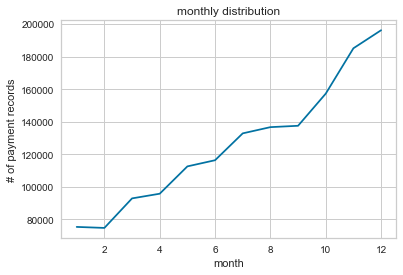

In [ ]:
# monthly 
month_freq = df.groupby('month')['month'].count()
plt.plot(month_freq.index, month_freq.values)
plt.xlabel("month")
plt.ylabel("# of payment records")
plt.title("monthly distribution")
plt.show()

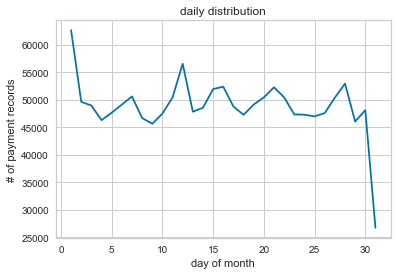

In [ ]:
# daily
day_freq = df.groupby('day')['day'].count()
plt.plot(day_freq.index, day_freq.values)
plt.xlabel("day of month")
plt.ylabel("# of payment records")
plt.title("daily distribution")
plt.show()

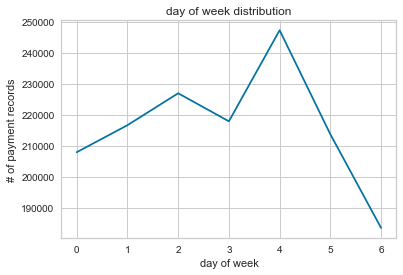

In [ ]:
# day of week Mon - Sun --> 0 - 6
dow_freq = df.groupby('day_of_week')['day_of_week'].count()
plt.plot(dow_freq.index, dow_freq.values)
plt.xlabel("day of week")
plt.ylabel("# of payment records")
plt.title("day of week distribution")
plt.show()

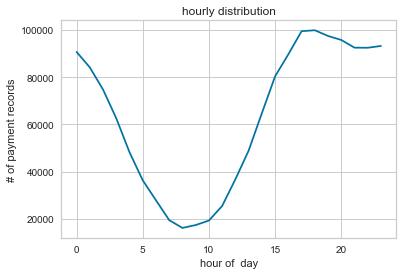

In [ ]:
# hourly
hour_freq = df.groupby('hour')['hour'].count()
plt.plot(hour_freq.index, hour_freq.values)
plt.xlabel("hour of  day")
plt.ylabel("# of payment records")
plt.title("hourly distribution")
plt.show()

# Merchant Classification

Lets create the dataframe in terms of merchants

In [ ]:
# count the number of records for each merchant
df_group_by_merchant = df.groupby('merchant')['merchant'].count().reset_index(name="count")

# create a column for total_amount
col_total_amount = df.groupby('merchant')['amount_usd_in_cents'].sum()
df_group_by_merchant['total_amount'] = col_total_amount.values

# create the average amount per merchant 
df_group_by_merchant['avg_amount'] = df_group_by_merchant['total_amount'] / df_group_by_merchant['count']

# create columns for months
for month in months_one_hot.columns:
    col_month = df.groupby('merchant')[month].sum()
    df_group_by_merchant[month] = col_month.values

# create columns for weeks
for dow in day_of_week.columns:
    col_dow = df.groupby('merchant')[dow].sum()
    df_group_by_merchant[dow] = col_dow.values

# use seasonal data to replace month data
# according to the month freq trend, we assume spring = 1-3, summer = 4-6, fall = 7-9, winter = 10-12
seasons = ['spring', 'summer', 'fall', 'winter']
idx = 1
for se in seasons:
    tmp_col1 = 'month_' + str(idx)
    tmp_col2 = 'month_' + str(idx + 1)
    tmp_col3 = 'month_' + str(idx + 2)
    df_group_by_merchant[se] = df_group_by_merchant[tmp_col1] + df_group_by_merchant[tmp_col2] + df_group_by_merchant[tmp_col3]
    idx += 3
    
for col in months_one_hot.columns:
    df_group_by_merchant = df_group_by_merchant.drop([col], axis=1)

# split a day into 3 ranges. 0-4, 5-13, 14-23
temp_daily = df.groupby('merchant')['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
    'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'].sum()

df_group_by_merchant['time_0_to_4'] = temp_daily[['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4']].sum(axis=1).values
df_group_by_merchant['time_5_to_13'] = temp_daily[['hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13']].sum(axis=1).values
df_group_by_merchant['time_14_to_23'] = temp_daily[['hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23']].sum(axis=1).values

In [ ]:
df_group_by_merchant.head()

,merchant,count,total_amount,avg_amount,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,spring,summer,fall,winter,time_0_to_4,time_5_to_13,time_14_to_23
0,0002b63b92,1,3379,3379.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0002d07bba,4,89278,22319.500000,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,1.0,3.0
2,00057d4302,28,29521,1054.321429,0.0,17.0,0.0,0.0,11.0,0.0,0.0,0.0,17.0,11.0,0.0,28.0,0.0,0.0
3,000bcff341,1,7826,7826.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,000ddbf0ca,1,10299,10299.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df_group_by_merchant.describe()

,count,total_amount,avg_amount,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,spring,summer,fall,winter,time_0_to_4,time_5_to_13,time_14_to_23
count,14351.000000,1.435100e+04,1.435100e+04,14351.000000,14351.000000,14351.000000,14351.000000,14351.000000,14351.000000,14351.000000,14351.000000,14351.000000,14351.000000,14351.000000,14351.000000,14351.000000,14351.000000
mean,105.478294,1.633296e+06,3.810458e+04,17.226047,14.487562,14.890321,12.787820,15.181520,15.093931,15.811093,16.946763,22.633057,28.368128,37.530346,25.109400,17.280608,63.088287
std,527.717966,6.431726e+06,1.415186e+05,87.676754,79.291155,88.259112,72.336428,76.984004,78.696686,110.198981,148.429352,138.848969,149.641925,205.054142,153.309723,109.274324,318.036894
min,1.000000,2.010000e+02,2.010000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.626300e+04,5.738182e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,11.000000,1.602620e+05,1.096500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,1.000000,2.000000,3.000000,2.000000,1.000000,6.000000
75%,45.000000,8.230995e+05,2.732122e+04,7.000000,5.000000,5.000000,4.000000,6.000000,6.000000,6.000000,3.000000,7.000000,9.000000,14.000000,9.000000,6.000000,25.000000
max,25512.000000,2.369072e+08,8.887465e+06,3750.000000,3569.000000,4812.000000,3619.000000,3507.000000,3681.000000,9012.000000,11020.000000,6388.000000,7315.000000,9326.000000,9314.000000,4869.000000,12173.000000


The features are very skewed

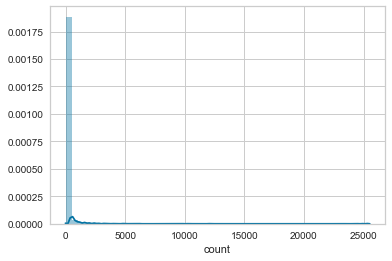

In [ ]:
val = df_group_by_merchant['count']
sns.distplot(val)

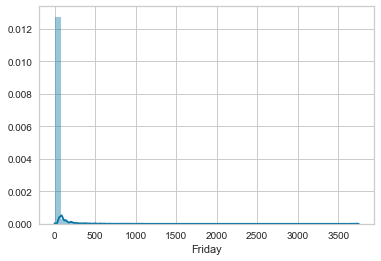

In [ ]:
val = df_group_by_merchant['Friday']
sns.distplot(val)

After we take logs to the features

[Text(0.5, 1.0, 'log count')]

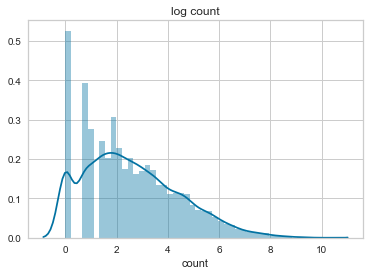

In [ ]:
val = df_group_by_merchant['count']
sns.distplot(np.log(val)).set(title='log count')

[Text(0.5, 1.0, 'log friday')]

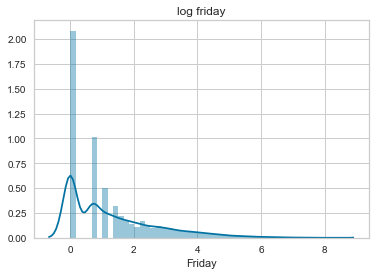

In [ ]:
val = df_group_by_merchant['Friday']
sns.distplot(np.log(val + 1)).set(title='log friday')

In [ ]:
# copy the data
df_group_by_merchant_copy = df_group_by_merchant.copy()

In [ ]:
df_group_by_merchant

,merchant,count,total_amount,avg_amount,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,spring,summer,fall,winter,time_0_to_4,time_5_to_13,time_14_to_23
0,0002b63b92,1,3379,3379.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0002d07bba,4,89278,22319.500000,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,1.0,3.0
2,00057d4302,28,29521,1054.321429,0.0,17.0,0.0,0.0,11.0,0.0,0.0,0.0,17.0,11.0,0.0,28.0,0.0,0.0
3,000bcff341,1,7826,7826.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,000ddbf0ca,1,10299,10299.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14346,ffd3e45675,5,72626,14525.200000,0.0,1.0,0.0,0.0,3.0,1.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,2.0
14347,ffe1f6b51a,53,281616,5313.509434,5.0,9.0,8.0,8.0,7.0,8.0,8.0,6.0,7.0,18.0,22.0,18.0,13.0,22.0
14348,ffe26b900d,81,959113,11840.901235,12.0,13.0,10.0,3.0,9.0,17.0,17.0,25.0,11.0,28.0,17.0,16.0,10.0,55.0
14349,ffec05edb9,3,15934,5311.333333,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0


now, we split the dataset into two big groups: the fresh merchants and the regular merchants

In [ ]:
# the fresh merchants
df_fresh_merchant = df_group_by_merchant[df_group_by_merchant['count'] <= 11]    # median is 11

In [ ]:
# the regular merchants
df_regular_merchant = df_group_by_merchant[df_group_by_merchant['count'] > 11]    # median is 11

## Fresh merchants classification

In [ ]:
# we only preserve merchant avg_amount for fresh merchants
df_fresh_merchant = df_fresh_merchant[['merchant','avg_amount']]
df_fresh_merchant_copy = df_fresh_merchant.copy()

df_fresh_merchant['avg_amount'] = np.log(df_fresh_merchant['avg_amount'] + 1)

now, the log avg_amount looks like a normal distribution

[Text(0, 0.5, 'frequency'), Text(0.5, 0, 'log avg_amount')]

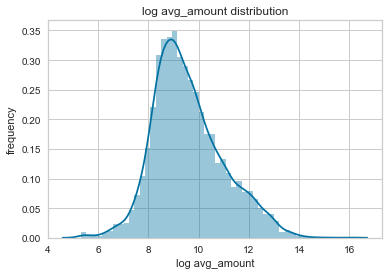

In [ ]:
val = df_fresh_merchant['avg_amount']
ax = sns.distplot(val)
ax.set_title("log avg_amount distribution")
ax.set(xlabel='log avg_amount', ylabel='frequency')


In [ ]:
# for reusability, we create this standardlize function
def standardlize_df(df):
    scaler = StandardScaler()
    scaler.fit(df)
    scaled = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaler.transform(df),columns= df.columns )
    return scaled_df

In [ ]:
df_fresh_merchant = df_fresh_merchant.drop(['merchant'], axis=1)
X_fresh = standardlize_df(df_fresh_merchant)

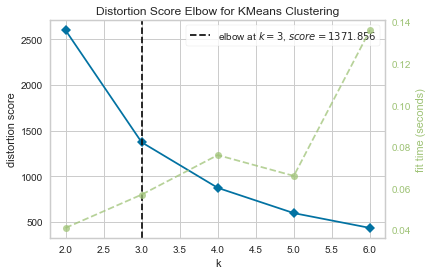

In [ ]:
Elbow_M = KElbowVisualizer(KMeans(init='k-means++'), k=6)
Elbow_M.fit(X_fresh)
Elbow_M.show()

the elbow method suggests that k = 3

In [ ]:
# fit model and predict clusters
model = KMeans(init='k-means++', n_clusters=3)
yhat = model.fit_predict(X_fresh)
df_fresh_merchant_copy["clusters"] = yhat
X_fresh["clusters"] = yhat

In [ ]:
df_fresh_merchant_copy

,merchant,avg_amount,clusters
0,0002b63b92,3379.000000,2
1,0002d07bba,22319.500000,0
3,000bcff341,7826.000000,2
4,000ddbf0ca,10299.000000,0
7,001f7b7a4f,6444.000000,2
...,...,...,...
14342,ffc46fd720,3343.000000,2
14343,ffc5a319bb,361034.000000,1
14345,ffd3284f86,8058.600000,2
14346,ffd3e45675,14525.200000,0


the plot of the clusters

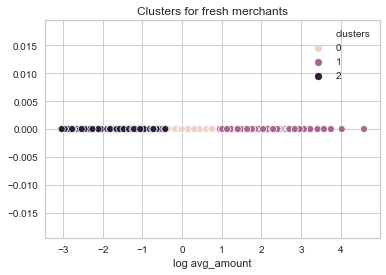

In [ ]:
ax = sns.scatterplot(data = X_fresh,
                     x=X_fresh["avg_amount"], 
                     y=[0] * len(X_fresh),
                     hue=X_fresh["clusters"])
ax.set_title("Clusters for fresh merchants")
ax.set(xlabel='log avg_amount')

plt.legend()
plt.show()

## Regular merchants classification

In [ ]:
df_regular_merchant

,merchant,count,total_amount,avg_amount,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,spring,summer,fall,winter,time_0_to_4,time_5_to_13,time_14_to_23
2,00057d4302,28,29521,1054.321429,0.0,17.0,0.0,0.0,11.0,0.0,0.0,0.0,17.0,11.0,0.0,28.0,0.0,0.0
5,000ed1585f,62,1647267,26568.822581,14.0,8.0,2.0,8.0,9.0,10.0,11.0,14.0,19.0,17.0,12.0,9.0,16.0,37.0
6,000f8c3297,290,3455191,11914.451724,57.0,15.0,3.0,0.0,80.0,59.0,76.0,29.0,74.0,69.0,118.0,48.0,135.0,107.0
10,002a66c0e1,102,3555151,34854.421569,35.0,3.0,44.0,4.0,13.0,0.0,3.0,15.0,31.0,26.0,30.0,33.0,21.0,48.0
14,0042aadfdf,144,806978,5604.013889,26.0,21.0,19.0,17.0,15.0,31.0,15.0,60.0,84.0,0.0,0.0,23.0,61.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14340,ffb94e1865,3141,25569960,8140.706781,373.0,779.0,351.0,342.0,343.0,532.0,421.0,80.0,112.0,158.0,2791.0,891.0,545.0,1705.0
14344,ffc99ae470,26,882908,33958.000000,0.0,0.0,0.0,0.0,0.0,26.0,0.0,8.0,7.0,5.0,6.0,0.0,0.0,26.0
14347,ffe1f6b51a,53,281616,5313.509434,5.0,9.0,8.0,8.0,7.0,8.0,8.0,6.0,7.0,18.0,22.0,18.0,13.0,22.0
14348,ffe26b900d,81,959113,11840.901235,12.0,13.0,10.0,3.0,9.0,17.0,17.0,25.0,11.0,28.0,17.0,16.0,10.0,55.0


In [ ]:
df_regular_merchant_copy = df_regular_merchant.copy()

if we check the correlation matrix, the correlation between most of the features is pretty high

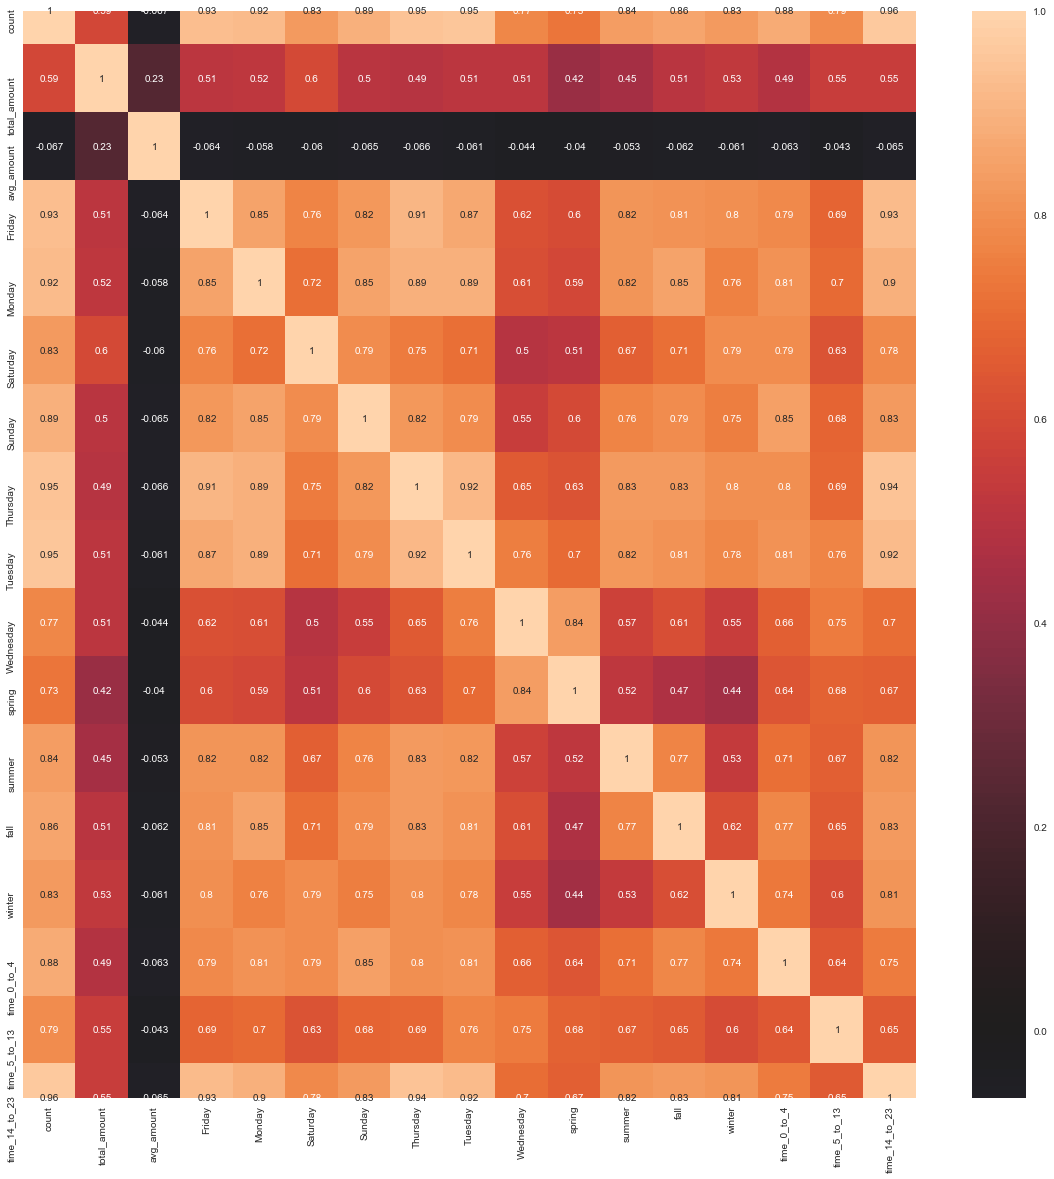

In [ ]:
corr_matrix = df_regular_merchant.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corr_matrix,annot=True, center=0)

In [ ]:
df_regular_merchant.columns

Index(['merchant', 'count', 'total_amount', 'avg_amount', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'spring',
       'summer', 'fall', 'winter', 'time_0_to_4', 'time_5_to_13',
       'time_14_to_23'],
      dtype='object')

In order to solve the correlation issue, we want all the time-related features to be divided by count

In [ ]:
# we use percentage for the columns except merchant count total_amount, avg_amount

for col in df_regular_merchant.columns[4:]:
    df_regular_merchant[col] = df_regular_merchant[col] / df_regular_merchant['count']

Now, we get un-correlated features

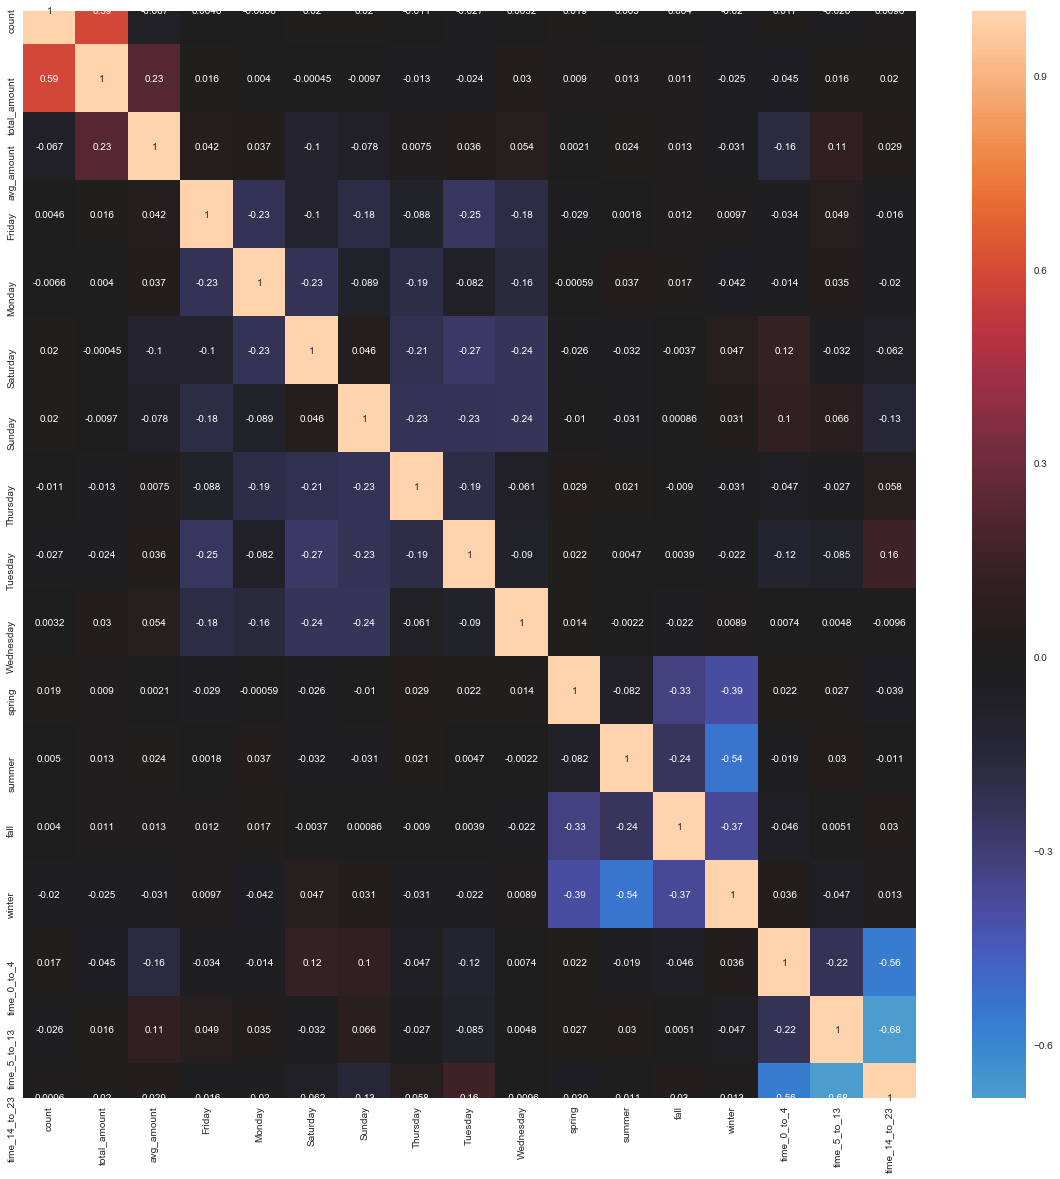

In [ ]:
corr_matrix = df_regular_merchant.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corr_matrix,annot=True, center=0)

still,we want to remove skewness for features

In [ ]:
# eliminate some skewness
for col in df_regular_merchant.columns[1:]:
    if col == 'count':
        df_regular_merchant[col] = np.log(df_regular_merchant[col].values - 11)
        
    elif col == 'winter':
        df_regular_merchant[col] = np.log(df_regular_merchant[col].values + 0.5)
        
    elif col in ['fall', 'time_0_to_4']:
        df_regular_merchant[col] = np.log(df_regular_merchant[col].values + 0.1)
        
    elif col ==  'time_14_to_23':
        df_regular_merchant[col] = np.sqrt(df_regular_merchant[col].values)
        
    else:
        df_regular_merchant[col] = np.log(df_regular_merchant[col].values + 0.05)

Create input data for model training

In [ ]:
df_regular_merchant = df_regular_merchant.drop(['merchant'], axis=1)

In [ ]:
# standardize the features since we need to calculate distances
X_regular = standardlize_df(df_regular_merchant)    

dimension reduction 

In [ ]:
# perform PCA

n = 10 # when n=10, we can cover more than 80% variance explaination
pca = PCA(n_components=n)
pca.fit(X_regular)
columns = []

for i in range(n):
    columns.append('col' + str(i + 1))
    
X_regular_PCA = pd.DataFrame(pca.transform(X_regular), 
                      columns=(columns))

In [ ]:
print(pca.explained_variance_ratio_)
np.sum(pca.explained_variance_ratio_)

[0.13376003 0.11080625 0.10040811 0.08551704 0.07556928 0.07247287
 0.07036306 0.05336278 0.05150277 0.04938928]


0.8031514732922831

train the model

Elbow Method to determine the number of clusters to be formed:


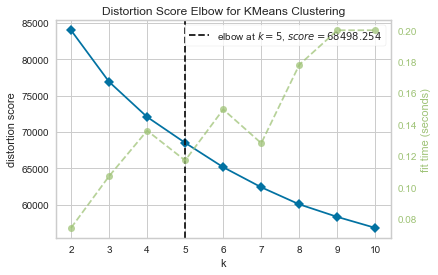

In [ ]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(init='k-means++'), k=10)
Elbow_M.fit(X_regular_PCA)
Elbow_M.show()

The elbow method suggests that k=5

In [ ]:
# fit model and predict clusters
model = KMeans(init='k-means++', n_clusters=5)
yhat = model.fit_predict(X_regular_PCA)
df_regular_merchant_copy["clusters"] = yhat
X_regular_PCA["clusters"] = yhat

lets take a glance at the clusters in 3D (we pick the top 3 principal components)

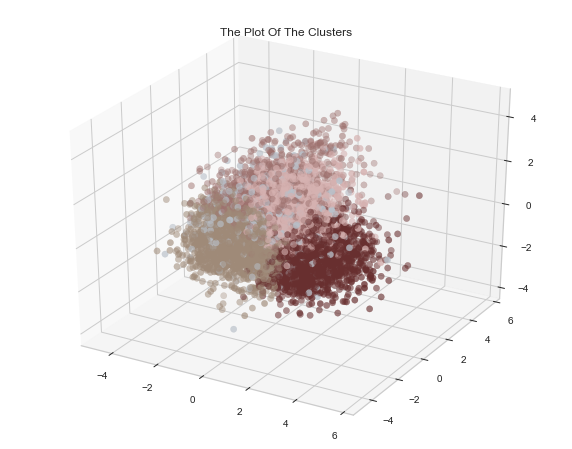

In [ ]:
x =X_regular_PCA["col1"]
y =X_regular_PCA["col2"]
z =X_regular_PCA["col3"]
from matplotlib import colors

pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78"]
cmap = colors.ListedColormap(pallet)

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=X_regular_PCA["clusters"], marker='o', cmap=cmap)
ax.set_title("The Plot Of The Clusters")
plt.show()

# Churn

first, we group the data by merchants and get some basic features

In [ ]:
# we want to first sort the original df for convenience
df = df.sort_values(by=['date'])

# count the number of payments for each merchant
df_group_by_merchant = df.groupby('merchant')['merchant'].count().reset_index(name="count")

# create a column for total_amount
col_total_amount = df.groupby('merchant')['amount_usd_in_cents'].sum()
df_group_by_merchant['total_amount'] = col_total_amount.values

# create the average amount per payment 
df_group_by_merchant['avg_amount'] = df_group_by_merchant['total_amount'] / df_group_by_merchant['count']

According to the defination of churn, we need to remove merchants who only have 1 paymente record

In [ ]:
# now we first remove merchants with count = 1
df_group_by_merchant = df_group_by_merchant[df_group_by_merchant['count'] > 1]

In [ ]:
df_group_by_merchant

,merchant,count,total_amount,avg_amount
1,0002d07bba,4,89278,22319.500000
2,00057d4302,28,29521,1054.321429
5,000ed1585f,62,1647267,26568.822581
6,000f8c3297,290,3455191,11914.451724
8,0020aefbd9,2,13004,6502.000000
...,...,...,...,...
14346,ffd3e45675,5,72626,14525.200000
14347,ffe1f6b51a,53,281616,5313.509434
14348,ffe26b900d,81,959113,11840.901235
14349,ffec05edb9,3,15934,5311.333333


now we compute the churn period

In [ ]:
# get the avg payment period (avg_days) per merchant 

first_date = df.groupby('merchant')['time'].min().astype('datetime64')
last_date = df.groupby('merchant')['time'].max().astype('datetime64')

for index,row in df_group_by_merchant.iterrows():
    temp_merchant = row['merchant']
    df_group_by_merchant.loc[index,'first_act'] = first_date[temp_merchant]
    df_group_by_merchant.loc[index,'last_act'] = last_date[temp_merchant]
    avg_days = (last_date[temp_merchant] - first_date[temp_merchant]).total_seconds() / 86400
    df_group_by_merchant.loc[index,'total_days'] = avg_days

df_group_by_merchant['avg_days'] = df_group_by_merchant['total_days'] / df_group_by_merchant['count']

df_group_by_merchant.avg_days.quantile(0.9)

42.50041280864199

In [ ]:
# the 90% quantile is 42.5, we round it to 43
churn_period = df_group_by_merchant.avg_days.quantile(0.9)

For simplicity, we directly create the first day timestamp and the last day timestamp

In [ ]:
first_date = df.iloc[0]['date']
last_date = df.iloc[-1]['date'] +  timedelta(days=1)

Now, we can create an attribute to show the time gap between last_date and the latest payment record timestamp for each merchant

In [ ]:
for index,row in df_group_by_merchant.iterrows():
    temp_merchant = row['merchant']
    to_last_day = (last_date - row['last_act']).total_seconds() / 86400
    df_group_by_merchant.loc[index,'range_to_last_day'] = to_last_day

In [ ]:
df_group_by_merchant

,merchant,count,total_amount,avg_amount,first_act,last_act,total_days,avg_days,range_to_last_day,churn
1,0002d07bba,4,89278,22319.500000,2034-10-11 17:02:26,2034-12-15 09:56:19,64.704086,16.176021,16.585891,0
2,00057d4302,28,29521,1054.321429,2033-05-30 01:30:52,2033-08-04 04:26:40,66.122083,2.361503,514.814815,1
5,000ed1585f,62,1647267,26568.822581,2033-02-18 14:39:03,2034-12-06 15:13:44,656.024086,10.581034,25.365463,0
6,000f8c3297,290,3455191,11914.451724,2033-09-29 22:30:34,2034-12-30 16:07:05,456.733692,1.574944,1.328414,0
8,0020aefbd9,2,13004,6502.000000,2034-05-30 21:55:06,2034-06-22 13:41:11,22.657002,11.328501,192.429734,1
...,...,...,...,...,...,...,...,...,...,...
14346,ffd3e45675,5,72626,14525.200000,2033-01-04 04:35:29,2033-01-27 00:32:30,22.831262,4.566252,703.977431,1
14347,ffe1f6b51a,53,281616,5313.509434,2033-06-04 00:11:12,2034-02-19 01:33:10,260.056921,4.906734,315.935301,1
14348,ffe26b900d,81,959113,11840.901235,2033-12-22 04:01:55,2034-11-21 14:02:34,334.417118,4.128606,40.414884,0
14349,ffec05edb9,3,15934,5311.333333,2034-01-25 20:14:36,2034-02-14 22:34:54,20.097431,6.699144,320.059097,1


Then we can create the label, churn to indicate whether the merchant is churn

In [ ]:
# comparing range_to_last_day with churn_period
df_group_by_merchant['churn'] = np.where(df_group_by_merchant['range_to_last_day'] > churn_period, 1, 0)

The churn data

In [ ]:
churn_merchant = df_group_by_merchant[df_group_by_merchant['churn'] == 1]

In [ ]:
churn_merchant['merchant']

2        00057d4302
8        0020aefbd9
9        0026f256ac
11       0037a192b4
14       0042aadfdf
            ...    
14342    ffc46fd720
14343    ffc5a319bb
14346    ffd3e45675
14347    ffe1f6b51a
14349    ffec05edb9
Name: merchant, Length: 6284, dtype: object

In [ ]:
df_group_by_merchant_copy = df_group_by_merchant.copy()

Finally, let's build a model for churn prediction. first, we need to preprocess the data

In [ ]:
# we want to convert the first_act and last_act into integers
for index,row in df_group_by_merchant.iterrows():
    temp_merchant = row['merchant']
    first_day = (row['first_act'] - first_date).total_seconds() / 86400
    df_group_by_merchant.loc[index,'first_act'] = int(first_day)
    
    last_day = (row['last_act'] - first_date).total_seconds() / 86400
    df_group_by_merchant.loc[index,'last_act'] = int(last_day)

In [ ]:
df_group_by_merchant.dtypes

merchant              object
count                  int64
total_amount           int64
avg_amount           float64
first_act              int64
last_act               int64
total_days           float64
avg_days             float64
range_to_last_day    float64
churn                  int32
dtype: object

check whether the training data is balanced

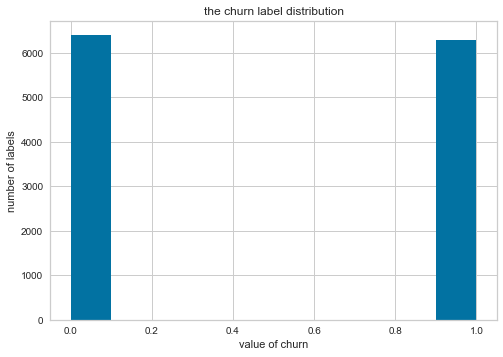

In [ ]:
plt.hist(df_group_by_merchant['churn'])
plt.title("the churn label distribution")
plt.xlabel("value of churn")
plt.ylabel("number of labels")
plt.show() 

let's check the correlation matrix

In [ ]:
X = df_group_by_merchant.drop(['merchant', 'churn'], axis=1)

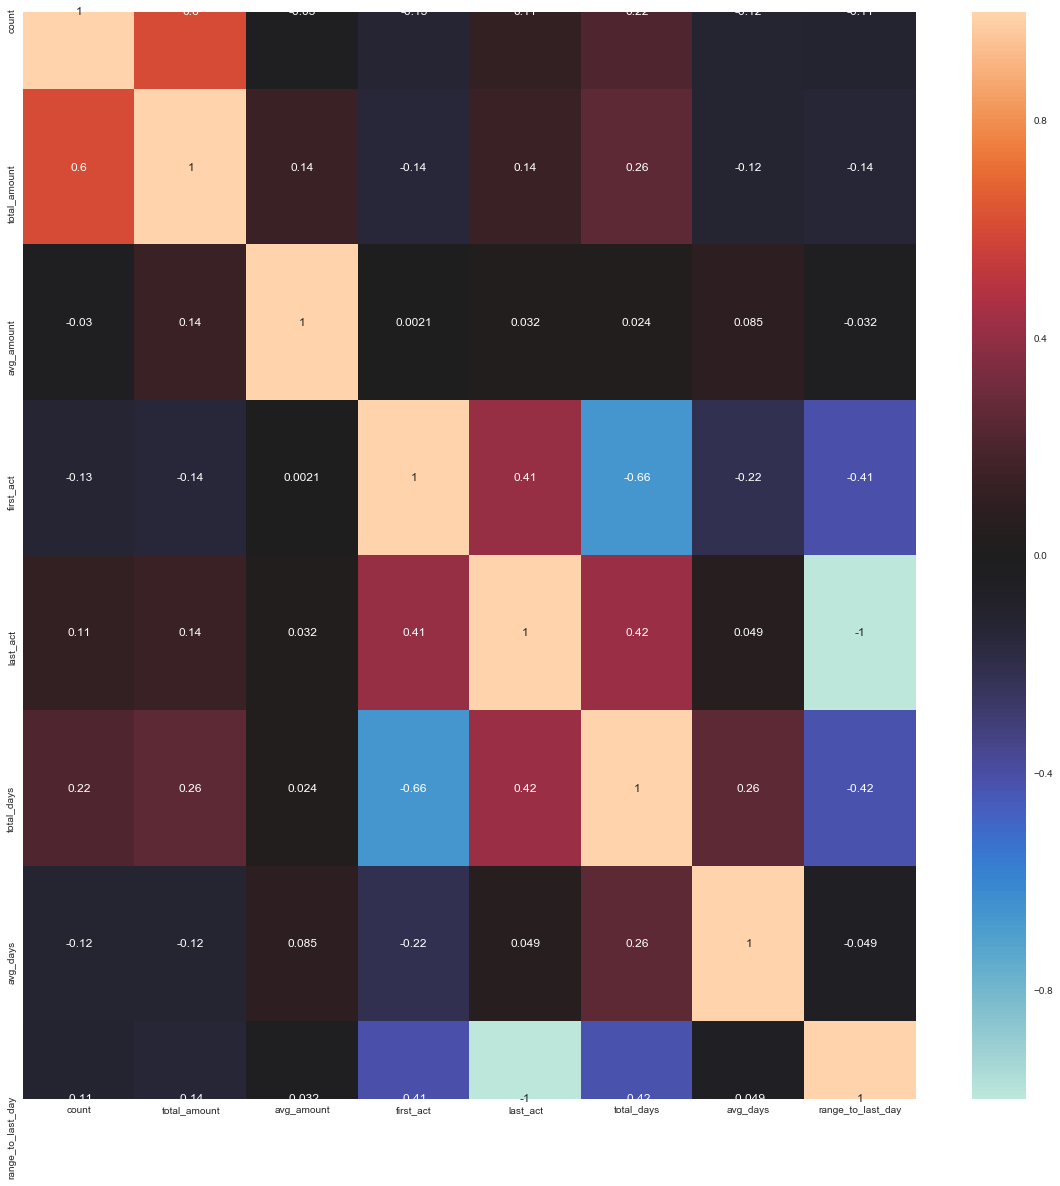

In [ ]:
corr_matrix = X.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corr_matrix,annot=True, center=0)

from the correlation matrix, count and total_amount is a little bit correlated, so we can remove either of them

In [ ]:
X = X.drop(['total_amount'], axis=1)


Since we use range_to_last_day and  to generate the churn label. To train the model, we should first remove the feature. Otherwise,the model will be overfitted. In the future, this feature will be updated by the time gap from the latest record timestamp and the current day.

In [ ]:
X = X.drop(['range_to_last_day',  'last_act'], axis=1)

In [ ]:
y = df_group_by_merchant.iloc[:,-1]

Then, we are going to select the model and train

In [ ]:
learning_rate = [0.1, 0.2, 0.5, 0.05, 0.01]
for lr in learning_rate:
    gbc = GradientBoostingClassifier(learning_rate=lr)
    cv_results = cross_validate(gbc, X, y,scoring='roc_auc', cv=5)
    print(lr, cv_results['test_score'], np.mean(cv_results['test_score']))

0.1 [0.99642652 0.99739428 0.99757638 0.9985416  0.9974844 ] 0.9974846378078371
0.2 [0.99797941 0.99862209 0.99894777 0.99942696 0.99901551] 0.9987983481883751
0.5 [0.99860715 0.99881103 0.99925853 0.99960844 0.99940521] 0.999138072614819
0.05 [0.99216097 0.99354614 0.99400544 0.9953529  0.99268813] 0.9935507174651008
0.01 [0.95529717 0.95842376 0.95765246 0.96513804 0.96096609] 0.9594955035714957


Wow, actually all of the learning rates are impressive. Here, we just choose 0.5 and make prediction

In [ ]:
# make prediction
gbc = GradientBoostingClassifier(learning_rate=0.5)
model = gbc.fit(X, y)

df_group_by_merchant['predicted_churn'] = model.predict(X)

Now, we can try to find out the merchants who are likely to churn

In [ ]:
# select merchants who has different churn and predicted_churn values
df_diff = df_group_by_merchant[df_group_by_merchant['churn'] != df_group_by_merchant['predicted_churn']]

In [ ]:
# get the merchants who have churn = 0. so it means the model predict them to be churn,thougth they are not churn now
df_diff[df_diff['churn'] == 0]

,merchant,count,total_amount,avg_amount,first_act,last_act,total_days,avg_days,range_to_last_day,churn,predicted_churn
576,0a4da2ae03,5,30298,6059.600000,460,689,229.452292,45.890458,40.399294,0,1
1450,19bcda3c29,3,43078,14359.333333,651,689,38.196690,12.732230,40.173090,0,1
8172,92643c7707,155,1455738,9391.858065,671,688,16.212280,0.104595,41.966829,0,1
14176,fd30f4a268,3,83745,27915.000000,589,687,98.029433,32.676478,42.476250,0,1


Besides, let's focus on the probabilities of the predicted_churn

In [ ]:
# lets add the prob for churn 0, prob for churn 1 and absolute difference between these two probabilities
predict_prob = model.predict_proba(X)
df_group_by_merchant['predicted_0_prob'] = predict_prob[:, 0]
df_group_by_merchant['predicted_1_prob'] = predict_prob[:, 1]
df_group_by_merchant['abs_prob_diff'] = np.abs(df_group_by_merchant['predicted_0_prob']  - df_group_by_merchant['predicted_1_prob'])

In [ ]:
# get the merchant with churn 0
df_group_by_merchant_0 = df_group_by_merchant[df_group_by_merchant['churn'] == 0]
# get the merchant with churn and predicted_churn are both 0
df_group_by_merchant_0_0 = df_group_by_merchant_0[df_group_by_merchant_0['predicted_churn'] == 0]

There are merchant which has relatively low probability of being not churned. They are also likely to be churned in the future.

In [ ]:
df_group_by_merchant_0_0[df_group_by_merchant_0['abs_prob_diff'] < 0.2]

,merchant,count,total_amount,avg_amount,first_act,last_act,total_days,avg_days,range_to_last_day,churn,predicted_churn,predicted_0_prob,predicted_1_prob,abs_prob_diff
265,04a764b433,6,36606,6101.000000,676,688,12.037118,2.006186,41.314618,0,0,0.559688,0.440312,0.119376
2936,341eef4f16,10,64505,6450.500000,222,687,465.154664,46.515466,42.153935,0,0,0.586808,0.413192,0.173617
5503,633375ea72,3,21307,7102.333333,644,689,44.641308,14.880436,40.466528,0,0,0.572449,0.427551,0.144898
5865,6983d0b1f6,5,11184,2236.800000,676,691,15.469421,3.093884,38.199803,0,0,0.569658,0.430342,0.139315
7490,85d854dba6,58,320457,5525.120690,345,688,342.948333,5.912902,41.903368,0,0,0.577567,0.422433,0.155135
8300,948c00f609,55,716198,13021.781818,463,688,224.335023,4.078819,41.910023,0,0,0.576211,0.423789,0.152422
10026,b36f195561,29,468980,16171.724138,528,688,159.874618,5.512918,41.190428,0,0,0.584561,0.415439,0.169122
12588,e0b65260bd,44,252899,5747.704545,374,687,313.031563,7.114354,42.387697,0,0,0.598629,0.401371,0.197258


In [ ]:
# merchants who are highly likely to churn in the near future
# df_group_by_merchant_0_0[df_group_by_merchant_0['abs_prob_diff'] < 0.2]
# df_diff[df_diff['churn'] == 0]